# Enhancing Recommender System using Machine Learning Sentiment Analysis Based on E-Commerce

## Data Loading

In [1]:
import pandas as pd 
import numpy as np 
import re
from string import punctuation
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
from imblearn import over_sampling
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense,LSTM
from tensorflow.keras.callbacks import EarlyStopping
import kerastuner as kt
import numpy as np
import tensorflow as tf
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

from kerastuner.tuners import RandomSearch
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score , f1_score, accuracy_score,roc_auc_score

C:\Users\User\AppData\Local\Temp\ipykernel_13508\3501975049.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


In [2]:
df = pd.read_json('C:/Users/User/Documents/workspace/com.mcast/GAN-Recommender-System/data/Cell_Phones_and_Accessories_5.json' , lines = True)
df.head(1)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A30TL5EWN6DFXT,120401325X,christina,"[0, 0]",They look good and stick good! I just don't li...,4,Looks Good,1400630400,"05 21, 2014"


## Data Exploration

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194439 entries, 0 to 194438
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviewerID      194439 non-null  object
 1   asin            194439 non-null  object
 2   reviewerName    190920 non-null  object
 3   helpful         194439 non-null  object
 4   reviewText      194439 non-null  object
 5   overall         194439 non-null  int64 
 6   summary         194439 non-null  object
 7   unixReviewTime  194439 non-null  int64 
 8   reviewTime      194439 non-null  object
dtypes: int64(2), object(7)
memory usage: 13.4+ MB


In [4]:
df['overall'].describe()

count    194439.000000
mean          4.129912
std           1.222499
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: overall, dtype: float64

In [5]:
df.shape

(194439, 9)

In [6]:
df.isnull().sum()

reviewerID           0
asin                 0
reviewerName      3519
helpful              0
reviewText           0
overall              0
summary              0
unixReviewTime       0
reviewTime           0
dtype: int64

In [7]:
for column in df.columns:
    if df[column].apply(lambda x: isinstance(x, list)).any():
        df[column] = df[column].apply(lambda x: tuple(x) if isinstance(x, list) else x)

df.duplicated().sum()

0

## Data Cleaning & Visualisation

In [8]:
df = df.dropna()

In [9]:
def MostWordsUsed(txt , n_words) : 
    all_text = ''.join(df[txt].values) 
    all_text = re.sub(r'\d+', '', all_text) # numbers
    all_text = re.sub(r'[^\w\s]', '', all_text) # special characters
    
    words = all_text.split() 
    punc = list(punctuation)
    words = [w for w in words if w not in punc] 

    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if not word in stop_words]
    word_counts = Counter(words)
    top_words = word_counts.most_common(n_words)
    return top_words

In [10]:
df['review_len'] = [len(text.split()) for text in df.reviewText]

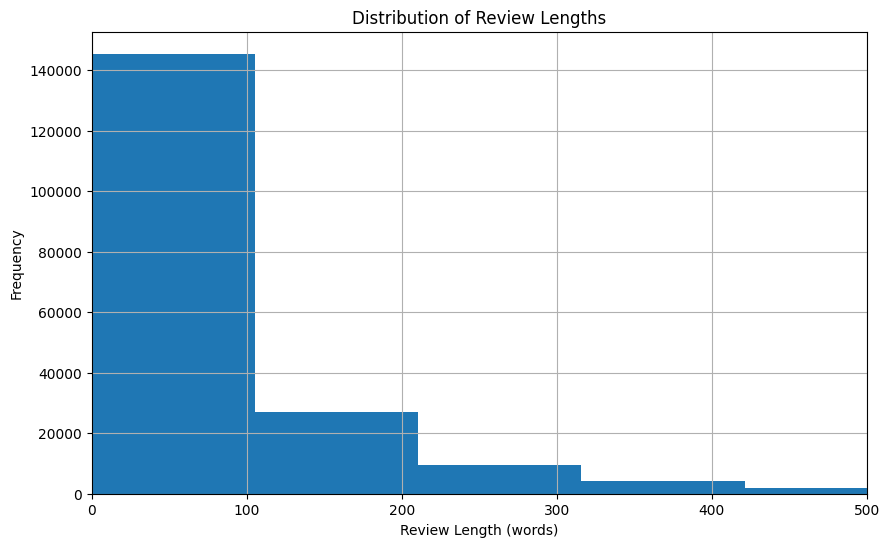

count    190920.000000
mean         91.976886
std         135.601597
min           0.000000
25%          28.000000
50%          48.000000
75%         101.000000
max        5263.000000
Name: review_len, dtype: float64


In [17]:
plt.figure(figsize=(10, 6))
df['review_len'].hist(bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (words)')
plt.ylabel('Frequency')
plt.xlim(0, 500)
plt.show()

# Display descriptive statistics for review lengths
print(df['review_len'].describe())

In [18]:
df = df[~(df['review_len'] < 20) & ~(df['review_len'] > 100)]

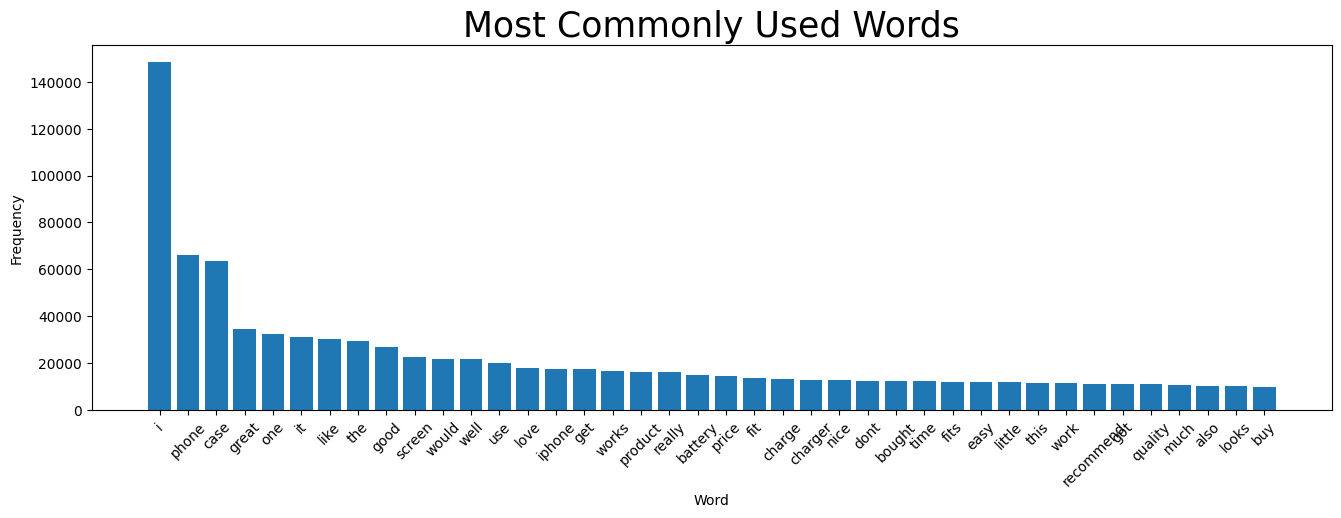

In [19]:
top_words = MostWordsUsed('reviewText', 40)

xaxis = [word[0] for word in top_words]
yaxis = [word[1] for word in top_words]

plt.figure(figsize=(16,5))
plt.bar(xaxis , yaxis)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words', fontsize=25)
plt.xticks(rotation=45)
plt.subplots_adjust(bottom=0.15)
plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_13508\3373974165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='overall', data=df, palette='viridis')


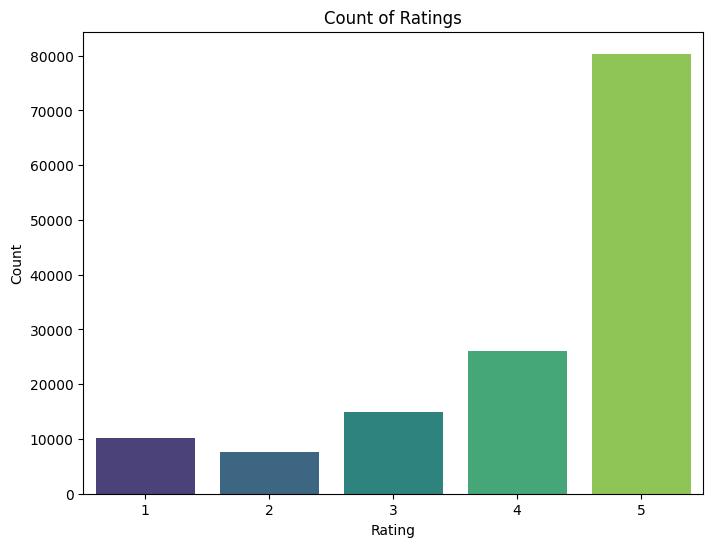

In [20]:
plt.figure(figsize=(8, 6))
sns.countplot(x='overall', data=df, palette='viridis')
plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [21]:
# For Sentiment Purposes we have decided to remove the 3 overall, since we need to put the overall as sentiments.
# 1,2 as 0 sentiment whereas 4,5 as 1 sentiment
df = df[df['overall'] != 3]

In [22]:
# Data Prepartion for the Sentiment Models
def DataPrep(text) : 
    text = text.lower()
    text = re.sub(r'\d+', '', text) # numbers
    text = re.sub(r'[^\w\s]', '', text) # special characters
    
    tokens = nltk.word_tokenize(text) 
    punc = list(punctuation)
    words = [word for word in tokens if word not in punc]
    stop_words = set(stopwords.words('english'))
    lemma = WordNetLemmatizer()
    words = [word.lower() for word in words if not word in stop_words]
    words = [lemma.lemmatize(word) for word in words]
    text = ' '.join(words)
    return text

df['reviewText'] = df['reviewText'].apply(DataPrep)

In [23]:
def rating_to_sentiment(rating):
    if rating > 3:
        return 1
    elif rating < 3:
        return 0
    
# Apply the function to your DataFrame
df['sentiment'] = df['overall'].apply(rating_to_sentiment)

C:\Users\User\AppData\Local\Temp\ipykernel_13508\802467065.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['sentiment'], ax=axes[1], palette=color)
C:\Users\User\AppData\Local\Temp\ipykernel_13508\802467065.py:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.countplot(x=df['sentiment'], ax=axes[1], palette=color)


Text(0, 0.5, 'Count')

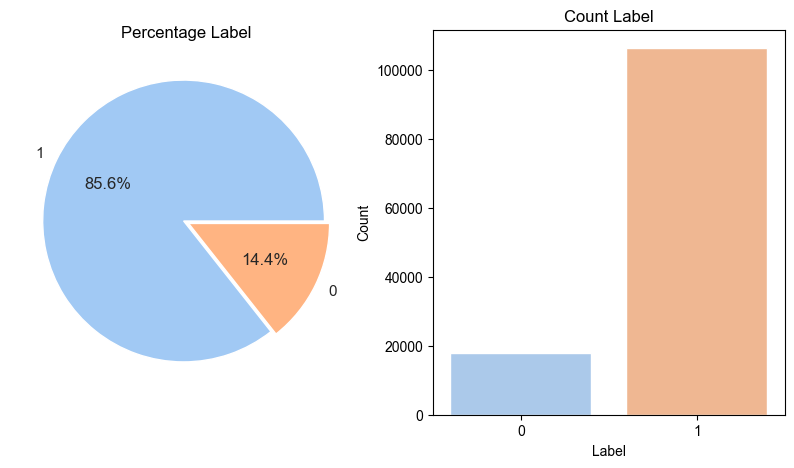

In [24]:
label_count = df['sentiment'].value_counts()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
sns.set_theme(style='darkgrid', palette='pastel')

color = sns.color_palette(palette='pastel')
explode = [0.02] * len(label_count)

axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

sns.countplot(x=df['sentiment'], ax=axes[1], palette=color)
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

Here we can see that there is a data inbalance, which will affect the training of the models. Hence, we need to use over_sampling so that this does not affect the training

In [25]:
label_count = df['sentiment'].value_counts()
label_count

sentiment
1    106459
0     17848
Name: count, dtype: int64

## Training

In [26]:
from sklearn.model_selection import train_test_split

x=df['reviewText']
y=df['sentiment']
print("Checking distribution of +ve and -ve review sentiment: \n{}".format(y.value_counts(normalize=True)))
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)
ros = over_sampling.RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(pd.DataFrame(X_train), pd.Series(y_train))
print("Checking distribution of +ve and -ve review sentiment after oversampling: \n{}".format(y_train.value_counts(normalize=True)))
X_train = X_train['reviewText'].tolist()


Checking distribution of +ve and -ve review sentiment: 
sentiment
1    0.85642
0    0.14358
Name: proportion, dtype: float64
Checking distribution of +ve and -ve review sentiment after oversampling: 
sentiment
1    0.5
0    0.5
Name: proportion, dtype: float64


### Training Sentiment Analysis Models

 Data was prepared for the sentiment models, using TfidfVectrizer for the models.

In [27]:
directory = './model/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [28]:
word_vectorizer = TfidfVectorizer()
word_vectorizer.fit(X_train)
print("No. of feature words: ",len(word_vectorizer.get_feature_names_out()))

X_train_transformed = word_vectorizer.transform(X_train)
X_test_transformed = word_vectorizer.transform(X_test.tolist())

# Save the TfidfVectorizer using pickle
with open(os.path.join(directory, 'word_vectorizer.pkl'), 'wb') as file:
    pickle.dump(word_vectorizer, file)

No. of feature words:  47613


In [29]:
# Evaluating the models
def evaluate_model(y_pred,y_actual):
    print(classification_report(y_true = y_actual, y_pred = y_pred))

Using GridSearch a hyperparameter tool to find the best fit for the models

In [59]:
#Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 300]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)
best_model_logistic = grid_search.best_estimator_
print("Best parameters found:", grid_search.best_params_)

y_pred_train = best_model_logistic.predict(X_train_transformed)
y_pred_test = best_model_logistic.predict(X_test_transformed)

print("Evaluation on Train dataset:")
evaluate_model(y_pred_train, y_train)
print("Evaluation on Test dataset:")
evaluate_model(y_pred_test, y_test)

#Saving the Model
logitisticRegression = './model/logit_model.pkl'
with open(logitisticRegression, 'wb') as file:
    pickle.dump(best_model_logistic, file)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'C': 100, 'max_iter': 100, 'solver': 'saga'}
Evaluation on Train dataset:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     74498
           1       0.97      0.96      0.97     74498

    accuracy                           0.97    148996
   macro avg       0.97      0.97      0.97    148996
weighted avg       0.97      0.97      0.97    148996

Evaluation on Test dataset:
              precision    recall  f1-score   support

           0       0.58      0.75      0.65      5332
           1       0.96      0.91      0.93     31961

    accuracy                           0.89     37293
   macro avg       0.77      0.83      0.79     37293
weighted avg       0.90      0.89      0.89     37293



c:\Users\User\anaconda3\envs\Naydel-Dissertation\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [61]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 200],  
    'max_depth': [None, 10, 20],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2] 
}

grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, verbose=2, n_jobs=-1)
grid_search_rf.fit(X_train_transformed, y_train)
best_rf_model = grid_search_rf.best_estimator_
print("Best parameters found for Random Forest:", grid_search_rf.best_params_)

y_pred_train_rf = best_rf_model.predict(X_train_transformed)
y_pred_test_rf = best_rf_model.predict(X_test_transformed)

print("Random Forest Evaluation on Train Dataset")
evaluate_model(y_pred_train_rf, y_train)
print("Random Forest Evaluation on Test Dataset")
evaluate_model(y_pred_test_rf, y_test)

randomForest = './model/RandomForest.pkl'
with open(randomForest, 'wb') as file:
    pickle.dump(best_rf_model, file)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters found for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Evaluation on Train Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74498
           1       1.00      1.00      1.00     74498

    accuracy                           1.00    148996
   macro avg       1.00      1.00      1.00    148996
weighted avg       1.00      1.00      1.00    148996

Random Forest Evaluation on Test Dataset
              precision    recall  f1-score   support

           0       0.89      0.40      0.55      5332
           1       0.91      0.99      0.95     31961

    accuracy                           0.91     37293
   macro avg       0.90      0.70      0.75     37293
weighted avg       0.91      0.91      0.89     37293



In [30]:
# SVM
from sklearn.svm import SVC

param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, verbose=2, n_jobs=-1)
grid_search_svm.fit(X_train_transformed, y_train)

best_svm_model = grid_search_svm.best_estimator_
print("Best parameters found:", grid_search_svm.best_params_)

y_pred_train_svm = best_svm_model.predict(X_train_transformed)
y_pred_test_svm = best_svm_model.predict(X_test_transformed)

print("SVM Evaluation on Train Dataset")
evaluate_model(y_pred_train_svm, y_train)
print("SVM Evaluation on Test Dataset")
evaluate_model(y_pred_test_svm, y_test)

SVM = './model/SVM.pkl'
with open(SVM, 'wb') as file:
    pickle.dump(best_svm_model, file)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best parameters found: {'C': 10, 'kernel': 'rbf'}
SVM Evaluation on Train Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74498
           1       1.00      1.00      1.00     74498

    accuracy                           1.00    148996
   macro avg       1.00      1.00      1.00    148996
weighted avg       1.00      1.00      1.00    148996

SVM Evaluation on Test Dataset
              precision    recall  f1-score   support

           0       0.84      0.62      0.72      5332
           1       0.94      0.98      0.96     31961

    accuracy                           0.93     37293
   macro avg       0.89      0.80      0.84     37293
weighted avg       0.93      0.93      0.92     37293



### Deep Learning Algorithms

We need to tokenize and sequence the reviewText for us to use deep learning algorithms. Also, for deep learning Keras Tuner (Random Search) is used for hyperparameter tuning

In [46]:
tokenizer = Tokenizer(oov_token='<UNK>')
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train) 
test_sequences = tokenizer.texts_to_sequences(X_test)

max_length = max(max(len(seq) for seq in train_sequences), max(len(seq) for seq in test_sequences))  
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')  
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post') 

vocab_size = len(tokenizer.word_index) + 1  

In [65]:
def build_lstm_model(hp):
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=128, step=32),
                  input_length=max_length),
        LSTM(units=hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=[BinaryAccuracy(name='accuracy')])
    return model

tuner = RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='model',
    project_name='lstm_tuning_project'
)

tuner.search_space_summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

tuner.search(train_padded, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[early_stopping],
             verbose=1)

best_model_LSTM = tuner.get_best_models(num_models=1)[0]

def evaluate_model_custom(model, X_train_padded, y_train, X_test_padded, y_test):
    y_pred_train = (model.predict(X_train_padded) > 0.5).astype("int32")
    y_pred_test = (model.predict(X_test_padded) > 0.5).astype("int32")
    print("LSTM Evaluation on Train Dataset")
    print(classification_report(y_train, y_pred_train))
    print("LSTM Evaluation on Test Dataset")
    print(classification_report(y_test, y_pred_test))
   
evaluate_model_custom(best_model_LSTM, train_padded, y_train, test_padded, y_test)
best_model_LSTM.save('best_lstm_model')

Trial 5 Complete [00h 04m 32s]
val_accuracy: 0.7737584114074707

Best val_accuracy So Far: 0.9978523254394531
Total elapsed time: 00h 24m 39s
1166/1166 [==============================] - 3s 3ms/step
LSTM Evaluation on Train Dataset
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     74498
           1       1.00      0.99      0.99     74498

    accuracy                           0.99    148996
   macro avg       0.99      0.99      0.99    148996
weighted avg       0.99      0.99      0.99    148996

LSTM Evaluation on Test Dataset
              precision    recall  f1-score   support

           0       0.63      0.67      0.65      5332
           1       0.94      0.93      0.94     31961

    accuracy                           0.90     37293
   macro avg       0.79      0.80      0.80     37293
weighted avg       0.90      0.90      0.90     37293



INFO:tensorflow:Assets written to: best_lstm_model\assets


INFO:tensorflow:Assets written to: best_lstm_model\assets


In [66]:
def build_cnn_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size,
                        output_dim=hp.Int('embedding_output_dim', min_value=32, max_value=128, step=32),
                        input_length=max_length))
    model.add(Conv1D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5, 7]),
                     activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(units=hp.Int('dense_units', min_value=10, max_value=100, step=10), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=5,  
    executions_per_trial=1,
    directory='model',  
    project_name='cnn_tuning'
)

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(train_padded, y_train,
             epochs=10,
             validation_split=0.1,
             callbacks=[early_stopping_cb],
             verbose=1,
             batch_size=256)

best_model_CNN = tuner.get_best_models(num_models=1)[0]

def evaluate_model_custom(model, X_train_padded, y_train, X_test_padded, y_test):
    y_pred_train = (model.predict(X_train_padded) > 0.5).astype("int32")
    y_pred_test = (model.predict(X_test_padded) > 0.5).astype("int32")
    print("CNN Evaluation on Train Dataset")
    print(classification_report(y_train, y_pred_train))
    print("CNN Evaluation on Test Dataset")
    print(classification_report(y_test, y_pred_test))

evaluate_model_custom(best_model_CNN, train_padded, y_train, test_padded, y_test)
best_model_CNN.save('best_cnn_model')

Trial 5 Complete [00h 00m 32s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 02m 28s
1166/1166 [==============================] - 1s 860us/step
CNN Evaluation on Train Dataset
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     74498
           1       1.00      1.00      1.00     74498

    accuracy                           1.00    148996
   macro avg       1.00      1.00      1.00    148996
weighted avg       1.00      1.00      1.00    148996

CNN Evaluation on Test Dataset
              precision    recall  f1-score   support

           0       0.76      0.62      0.68      5332
           1       0.94      0.97      0.95     31961

    accuracy                           0.92     37293
   macro avg       0.85      0.79      0.82     37293
weighted avg       0.91      0.92      0.91     37293



INFO:tensorflow:Assets written to: best_cnn_model\assets


INFO:tensorflow:Assets written to: best_cnn_model\assets


Looking through the models on which is the best

1166/1166 [==============================] - 4s 3ms/step


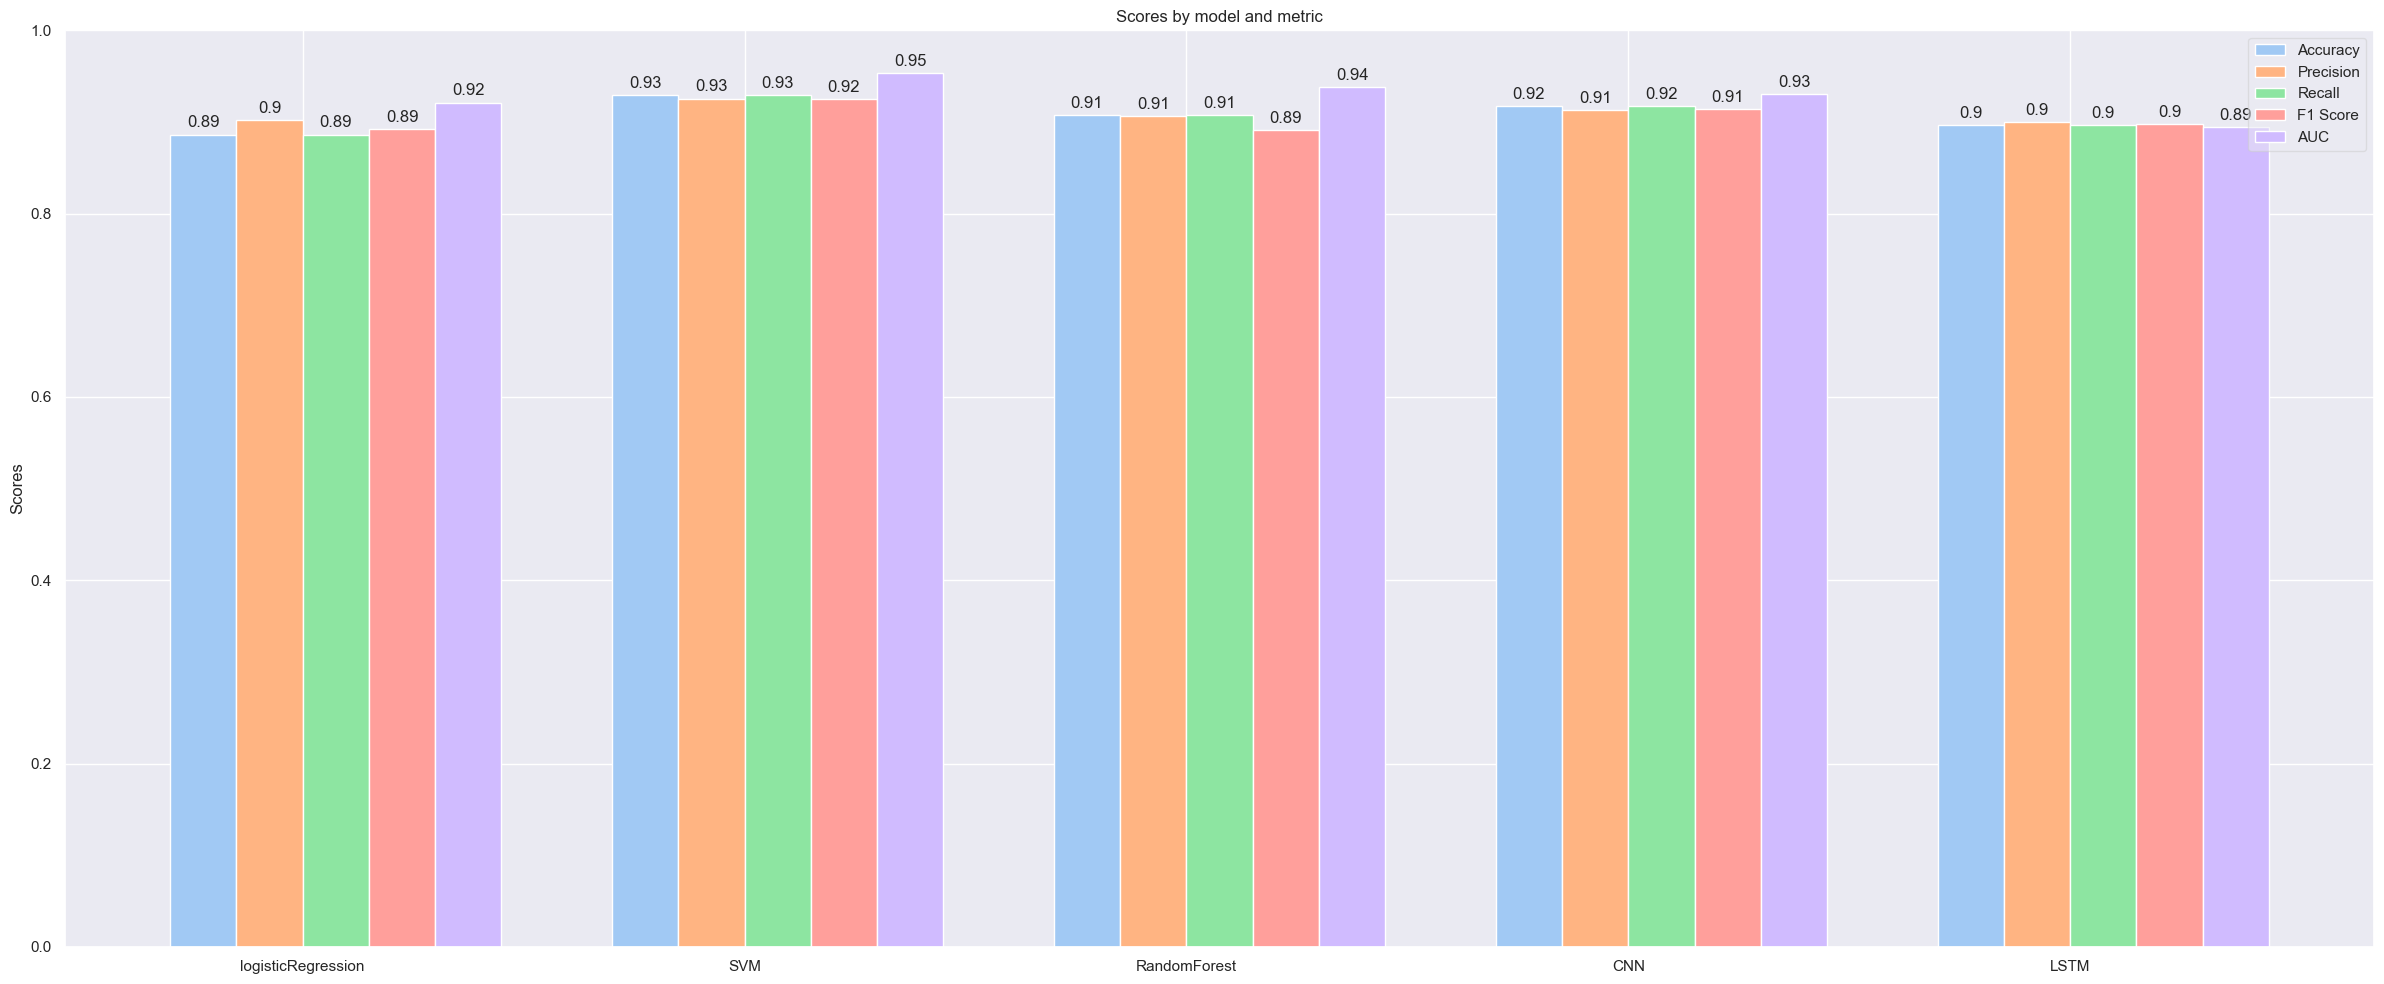

In [47]:
model_paths = {
    'logisticRegression': './model/logit_model.pkl',
    'SVM': './model/SVM.pkl',
    'RandomForest': './model/RandomForest.pkl',
    'CNN': './best_cnn_model', 
    'LSTM': './best_lstm_model',
}

model_metrics = {}

for model_name, model_path in model_paths.items():
    try:
        if model_name in [ 'SVM', 'logisticRegression', 'RandomForest']:
            with open(model_path, 'rb') as file:
                model = pickle.load(file)
            y_pred = model.predict(X_test_transformed)
            if hasattr(model, 'predict_proba'):
                y_scores = model.predict_proba(X_test_transformed)[:,1]
            elif hasattr(model, 'decision_function'):
                y_scores = model.decision_function(X_test_transformed)
            else:
                print(f"{model_name} does not support predict_proba or decision_function.")
                continue  
        elif model_name in ['CNN', 'LSTM']:
            model = load_model(model_path)
            y_scores = model.predict(test_padded).flatten()
            y_pred = (y_scores > 0.5).astype('int32').flatten()

        # Metrics calculation
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        auc = roc_auc_score(y_test, y_scores) if 'y_scores' in locals() else 'N/A'

        model_metrics[model_name] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'AUC': auc
        }
    except Exception as e:
        print(f"Error processing {model_name}: {e}")

labels = list(model_metrics.keys())
accuracy_scores = [metrics['Accuracy'] for metrics in model_metrics.values()]
precision_scores = [metrics['Precision'] for metrics in model_metrics.values()]
recall_scores = [metrics['Recall'] for metrics in model_metrics.values()]
f1_scores = [metrics['F1 Score'] for metrics in model_metrics.values()]
auc_scores = [metrics['AUC'] for metrics in model_metrics.values()]

x = np.arange(len(labels))
width = 0.15 

fig, ax = plt.subplots(figsize=(24, 10))
rects1 = ax.bar(x - width*1.5, accuracy_scores, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision_scores, width, label='Precision')
rects3 = ax.bar(x + width/2, recall_scores, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1 Score')
rects5 = ax.bar(x + width*2.5, auc_scores, width, label='AUC')

ax.set_ylabel('Scores')
ax.set_ylim(0, 1)
ax.set_title('Scores by model and metric')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper right', fancybox=True, framealpha=0.5)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

fig.tight_layout()
plt.show()

In [58]:
# Let's assume you have a dictionary of model_metrics as before
best_models_by_metric = {}

# Loop over each metric to find which model performs best for that metric
for metric in ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']:
    best_score = 0
    best_model = None
    for model, metrics in model_metrics.items():
        if metrics[metric] > best_score:
            best_score = metrics[metric]
            best_model = model
    best_models_by_metric[metric] = (best_model, best_score)

# Now best_models_by_metric contains the best model for each metric
for metric, (model, score) in best_models_by_metric.items():
    print(f"The best model for {metric} is {model} with a score of {score:.4f}")

# If you want to pick a model that is consistently good across multiple metrics:
from collections import Counter
most_common_model = Counter([best[0] for best in best_models_by_metric.values()]).most_common(1)
print(f"The most consistently good model across metrics is: {most_common_model[0][0]}")


The best model for Accuracy is SVM with a score of 0.9293
The best model for Precision is SVM with a score of 0.9257
The best model for Recall is SVM with a score of 0.9293
The best model for F1 Score is SVM with a score of 0.9248
The best model for AUC is SVM with a score of 0.9531
The most consistently good model across metrics is: SVM


### Training Recommender System

In [49]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

In [50]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['reviewerID', 'asin', 'overall']], reader)

In [35]:
trainset, testset = train_test_split(data, test_size=0.30, random_state=42)

## Model Creation

In [51]:
algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

rmse_no_sentiment = accuracy.rmse(predictions)
mae_no_sentiment = accuracy.mae(predictions)
print(f"RMSE (No Sentiment Analysis): {rmse_no_sentiment}, MAE (No Sentiment Analysis): {mae_no_sentiment}")

RMSE: 1.1990
MAE:  0.8697
RMSE (No Sentiment Analysis): 1.1989776477221785, MAE (No Sentiment Analysis): 0.8697062703605498


In [52]:
with open('./model/SVM.pkl', 'rb') as file:
    SVM_model = pickle.load(file)

In [53]:
reviewText_transformed = word_vectorizer.transform(df['reviewText'])

In [39]:
sentiment_scores = SVM.decision_function(reviewText_transformed)

In [54]:
df['SVM_sentiment_score'] = sentiment_scores
data_sentiment = Dataset.load_from_df(df[['reviewerID', 'asin', 'SVM_sentiment_score']], reader)

In [55]:
sentiment_scores_svm = (sentiment_scores - sentiment_scores.min()) / (sentiment_scores.max() - sentiment_scores.min())
df['SVM_sentiment_score'] = sentiment_scores_svm
data_sentiment_svm = Dataset.load_from_df(df[['reviewerID', 'asin', 'SVM_sentiment_score']], reader)

In [56]:
trainset_sentiment_svm, testset_sentiment_svm = train_test_split(data_sentiment_svm, test_size=0.30, random_state=42)

In [57]:
algo_sentiment_svm = SVD()
algo_sentiment_svm.fit(trainset_sentiment_svm)
predictions_sentiment_svm = algo_sentiment_svm.test(testset_sentiment_svm)

rmse_with_sentiment_svm = accuracy.rmse(predictions_sentiment_svm)
mae_with_sentiment_svm = accuracy.mae(predictions_sentiment_svm)
print(f"RMSE (With Linear SVM Sentiment Analysis): {rmse_with_sentiment_svm}, MAE (With Sentiment Analysis): {mae_with_sentiment_svm}")

RMSE: 0.4345
MAE:  0.4177
RMSE (With Linear SVM Sentiment Analysis): 0.4345404569877452, MAE (With Sentiment Analysis): 0.4177163214677785


In [61]:
df['adjusted_rating'] = df['overall'] + (df['SVM_sentiment_score'] * 0.5) 
df['adjusted_rating'] = df['adjusted_rating'].clip(lower=1, upper=5)

data_combined = Dataset.load_from_df(df[['reviewerID', 'asin', 'adjusted_rating']], reader)
trainset_combined, testset_combined = train_test_split(data_combined, test_size=0.30, random_state=42)
algo_combined = SVD()
algo_combined.fit(trainset_combined)
predictions_combined = algo_combined.test(testset_combined)
rmse_combined = accuracy.rmse(predictions_combined)
mae_combined = accuracy.mae(predictions_combined)
print(f"RMSE (Combined): {rmse_combined}, MAE (Combined): {mae_combined}")

RMSE: 1.1395
MAE:  0.7867
RMSE (Combined): 1.1395113916374873, MAE (Combined): 0.7867002314809921


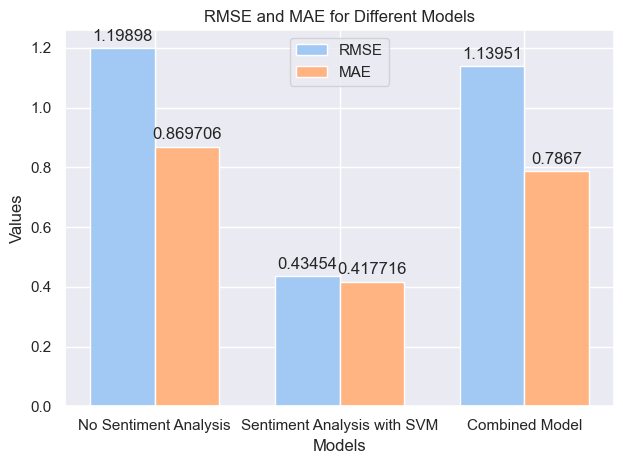

In [63]:
models = ["No Sentiment Analysis", "Sentiment Analysis with SVM", "Combined Model"]
rmse_values = [rmse_no_sentiment, rmse_with_sentiment_svm, rmse_combined]  
mae_values = [mae_no_sentiment, mae_with_sentiment_svm, mae_combined]   

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rmse_values, width, label='RMSE')
rects2 = ax.bar(x + width/2, mae_values, width, label='MAE')

ax.set_xlabel('Models')
ax.set_ylabel('Values')
ax.set_title('RMSE and MAE for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

In [64]:
def get_top_n_recommendations(predictions, n=10):
    top_n = {}
    for uid, iid, _, est, _ in predictions:
        if uid not in top_n:
            top_n[uid] = [(iid, est)]
        else:
            top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

import random

def get_sampled_anti_testset(trainset, user, item_sample=10000):
    trainset_items = set(trainset.ir.keys())
    trainset_users = set(trainset.ur.keys())
    
    if trainset.to_inner_uid(user) in trainset_users:
        user_items = set([j for (j, _) in trainset.ur[trainset.to_inner_uid(user)]])
        sample = random.sample(trainset_items - user_items, item_sample)
        anti_testset = [[user, trainset.to_raw_iid(item), trainset.global_mean] for item in sample]
        return anti_testset
    else:
        print(f"User {user} not found in the training set.")
        return []

user_id = 'A30TL5EWN6DFXT'
sampled_anti_testset = get_sampled_anti_testset(trainset_combined, user_id, item_sample=100)

if sampled_anti_testset:
    predictions = algo_combined.test(sampled_anti_testset)
    top_n_recommendations = get_top_n_recommendations(predictions, n=5)
    
    print(f"Top 5 recommendations for {user_id}:")
    for itemID, estimatedRating in top_n_recommendations[user_id]:
        print(f"Item: {itemID}, Estimated Rating: {estimatedRating}")

Top 5 recommendations for A30TL5EWN6DFXT:
Item: B006MK0ZD4, Estimated Rating: 4.788100841126396
Item: B00AAKGF72, Estimated Rating: 4.755232320008208
Item: B006JHU3DC, Estimated Rating: 4.752616409347736
Item: B0085QRJ5U, Estimated Rating: 4.747266224773453
Item: B00CE3IC74, Estimated Rating: 4.696636605652976


In [23]:
from collections import defaultdict
def get_top_n_recommendations(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n_recommendations = get_top_n_recommendations(predictions_sentiment_svm, n=5)

user_id = 'A30TL5EWN6DFXT'
recommended_items = top_n_recommendations.get(user_id, [])
print(f"Top recommended items for user {user_id}: {recommended_items}")

Top recommended items for user A30TL5EWN6DFXT: [('B004RDH8OM', 1), ('B008I6X802', 1), ('B003X6LPRK', 1)]
